<a href="https://colab.research.google.com/github/tkn13/datasci_project/blob/dev%2Fmodeling/modeling/Phai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tkn13/datasci_project
%cd datasci_project

Cloning into 'datasci_project'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 36 (delta 12), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 68.38 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/datasci_project


In [2]:
import sys
sys.path.append('/content/datasci_project')

In [3]:
import utils

utils.get_connection()

Mounted at /content/drive


'/content/drive/My Drive/datamine_shared/'

In [4]:
df = utils.load_data()
df.head()

Loading data_clean_v1.csv...


,ID,Old,Driving_experience,Distribution_channel,Policies_in_force,Max_policies,Max_products,Lapse,Payment,Cost_claims_year,...,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Has_lapsed,Years_with_company,Premium
0,3,40,20,0,1,2,1,0,0,0.0,...,85,1229,16030.0,5,0,3.999,1105,0,1,380.20
1,3,41,21,0,1,2,1,0,0,0.0,...,85,1229,16030.0,5,0,3.999,1105,0,2,393.50
2,3,42,22,0,1,2,1,0,0,0.0,...,85,1229,16030.0,5,0,3.999,1105,0,3,393.50
3,3,43,23,0,1,2,1,0,0,0.0,...,85,1229,16030.0,5,0,3.999,1105,0,4,395.47
4,6,49,25,0,1,2,2,0,0,0.0,...,87,1598,9927.0,4,0,4.250,1055,0,1,250.52


# **Lapse Prediction: Classification**


📂 Loading Data: data_clean_v1.csv ...
Loading data_clean_v1.csv...
Data Shape: (46016, 26)
------------------------------

✂️ Splitting Data...
Train Set: (36812, 23)
Test Set:  (9204, 23)

🤖 Training XGBoost Model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:03:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 --- Results ---


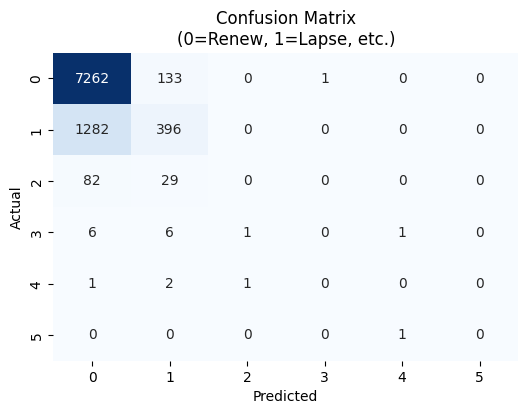


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      7396
           1       0.70      0.24      0.35      1678
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1

    accuracy                           0.83      9204
   macro avg       0.26      0.20      0.21      9204
weighted avg       0.80      0.83      0.79      9204

⭐ ROC-AUC Score (OVR): nan

💡 Top 10 Factors Driving Lapse (ปัจจัยที่ทำให้ลูกค้ายกเลิก):


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

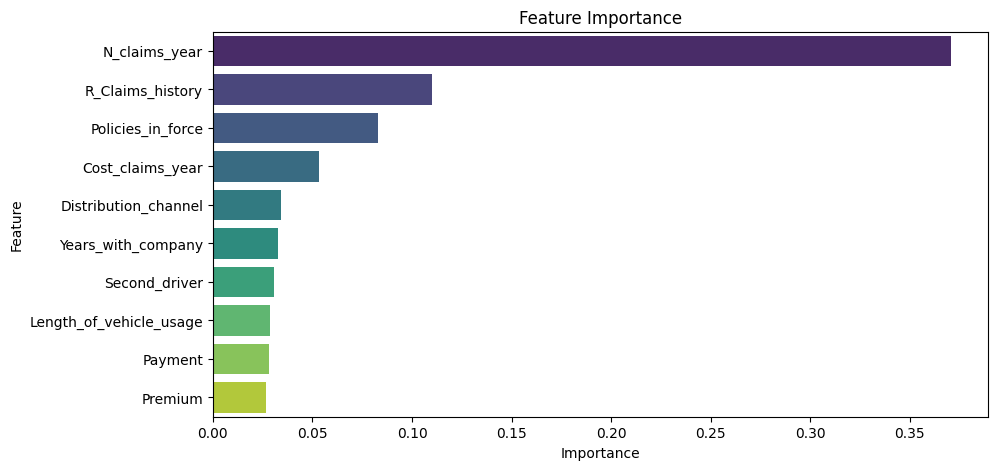

,Feature,Importance
8,N_claims_year,0.370692
10,R_Claims_history,0.109877
3,Policies_in_force,0.082694
7,Cost_claims_year,0.053053
2,Distribution_channel,0.034418
21,Years_with_company,0.032564
12,Second_driver,0.030676
13,Length_of_vehicle_usage,0.028443
6,Payment,0.028363
22,Premium,0.026600


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb

# 1. Load Data (ไฟล์ใหม่)
# ==========================================
print("📂 Loading Data: data_clean_v1.csv ...")
df = utils.load_data()

print(f"Data Shape: {df.shape}")
print("-" * 30)

# 2. Data Preparation
# ==========================================
# กำหนด Target
target_col = 'Lapse'

# ⚠️ ตัด Columns ที่ไม่ควรใช้เทรน
# - ID: ไม่เกี่ยวกับพฤติกรรม
# - Has_lapsed: ดูเหมือนจะเป็นค่าซ้ำกับ Target หรือค่าเฉลยในอดีต (ตัดกันเหนียว)
# - Cost_claims_year, N_claims_year: (Optional) ปกติถ้าทำนายล่วงหน้า เราอาจจะไม่รู้ยอดเคลมของปีนั้นๆ
#   แต่ถ้าโมเดลนี้รันตอนสิ้นปีเพื่อดูว่าจะต่ออายุไหม ก็ใส่ได้ (ในที่นี้ขอใส่ไว้เพื่อให้โมเดลเรียนรู้พฤติกรรม)
drop_cols = ['ID', 'Has_lapsed']

# แยก Features (X) และ Target (y)
# ถ้ามี Column ไหนไม่มีในไฟล์ มันจะข้ามไปเอง (errors='ignore')
X = df.drop(columns=[target_col] + drop_cols, errors='ignore')
y = df[target_col]

# จัดการ Categorical Data (ถ้ามี)
# ดูจากชื่อ Column ไฟล์ v1 น่าจะเป็นตัวเลขเกือบหมดแล้ว แต่เผื่อไว้สำหรับ Type_fuel หรือ Area
cat_cols = X.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print(f"🔠 Encoding Categorical: {list(cat_cols)}")
    le = LabelEncoder()
    for col in cat_cols:
        X[col] = X[col].astype(str)
        X[col] = le.fit_transform(X[col])

# 3. Train/Test Split
# ==========================================
print("\n✂️ Splitting Data...")
# แบ่งข้อมูล 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train Set: {X_train.shape}")
print(f"Test Set:  {X_test.shape}")

# 4. Model Training (XGBoost)
# ==========================================
print("\n🤖 Training XGBoost Model...")

# คำนวณ Ratio เพื่อแก้ปัญหาข้อมูลไม่สมดุล (คน Lapse น้อยกว่าคนอยู่ต่อ)
# scale_pos = float(np.sum(y == 0)) / np.sum(y == 1) # This parameter is not used in multiclass XGBoost

clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    # scale_pos_weight=scale_pos, # Removed as it's not applicable for multiclass with default objective
    eval_metric='mlogloss', # Changed to mlogloss for multiclass
    use_label_encoder=False,
    random_state=42
)

clf.fit(X_train, y_train)

# 5. Evaluation
# ==========================================
print("\n📊 --- Results ---")
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) # Get probabilities for all classes

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix\n(0=Renew, 1=Lapse, etc.)') # Updated title for multiclass
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Metrics Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
# Added multi_class='ovr' and labels to handle multiclass AUC
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', labels=np.unique(y))
print(f"⭐ ROC-AUC Score (OVR): {auc:.4f}")

# 6. Feature Importance (สำคัญมาก)
# ==========================================
print("\n💡 Top 10 Factors Driving Lapse (ปัจจัยที่ทำให้ลูกค้ายกเลิก):")
feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
feature_imp = feature_imp.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title('Feature Importance')
plt.show()

display(feature_imp)

# **Pricing Model: Regression**

📂 Loading Data: data_clean_v1.csv ...
Loading data_clean_v1.csv...

🤖 Training Pricing Model...

📊 Model Performance:
✅ R-Squared: 0.4138 (โมเดลอธิบายโครงสร้างราคาได้ 41.38%
💰 Mean Absolute Error: 70.80 (ทำนายเบี้ยคลาดเคลื่อนเฉลี่ย +/- 70.80 หน่วย)
📉 RMSE: 10737.92
📊 MAPE: 22.97%
📌 Median AE: 49.14 




/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3607 (\N{THAI CHARACTER THO THAHAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

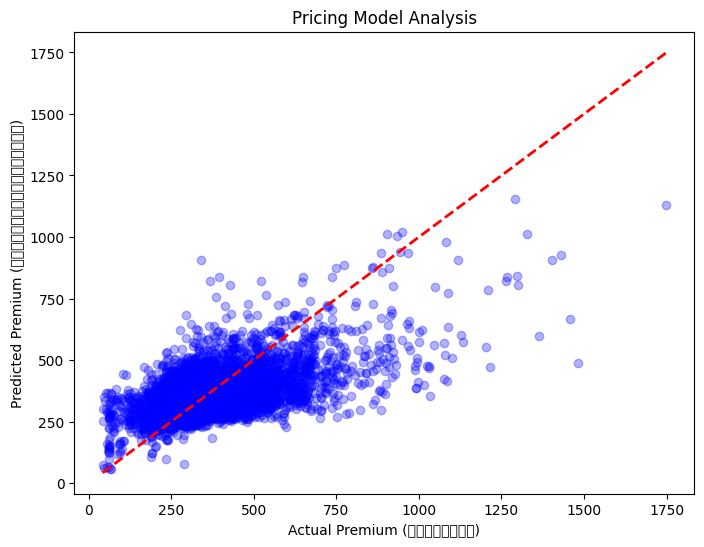


💡 What drives the Price? (ปัจจัยที่กำหนดราคา):


/tmp/ipython-input-173742468.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='magma')


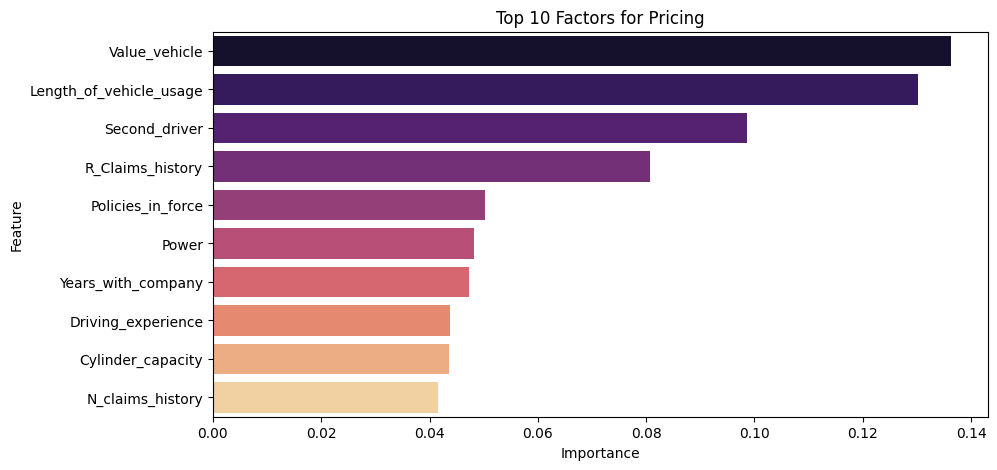


🚀 Risk-Based Optimization Insight

สรุปกลุ่มลูกค้าตามความคุ้มค่า (Pricing Segment):
Segment
1. Good (No Claim)                   7463
2. Profitable (Claim but Covered)     965
3. Loss Making (Underpriced)          776
Name: count, dtype: int64

⚠️ ตัวอย่างลูกค้าที่ควร 'ขึ้นเบี้ย' (Underpriced):


,Actual_Premium,Suggested_Premium,Actual_Claim_Cost,Value_vehicle,Old
6075,389.21,414.748505,36013.52,26315.0,53
16166,339.93,336.014801,21804.17,20750.0,57
8337,336.27,464.220642,16073.12,18520.0,49
15946,278.79,313.738922,14169.61,12500.0,60
28291,362.29,447.756805,13642.82,24720.0,68


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
import xgboost as xgb

# 1. Load Data
# ==========================================
print("📂 Loading Data: data_clean_v1.csv ...")
df = utils.load_data()

# 2. Data Preparation
# ==========================================
# Target ของเราคือ "Premium" (เบี้ยประกัน)
target_col = 'Premium'

# Features: ปัจจัยที่ใช้คิดราคา
# ตัด ID และตัวแปรที่เป็น "อนาคต" หรือ "ผลลัพธ์" ออก (เช่น Lapse, Payment)
# แต่เราเก็บ 'N_claims_history' ไว้ เพราะประวัติเคลมมีผลต่อเบี้ย (No Claim Bonus)
drop_cols = ['ID', 'Lapse', 'Has_lapsed', 'Date_lapse',
             'Payment', 'Cost_claims_year', 'N_claims_year']

# แยก X, y
X = df.drop(columns=[target_col] + drop_cols, errors='ignore')
y = df[target_col]

# 3. Train/Test Split
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training (XGBoost Regressor)
# ==========================================
print("\n🤖 Training Pricing Model...")

# ใช้ Regressor เพราะเราทำนาย "ราคา" (ตัวเลขต่อเนื่อง)
reg = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42
)

reg.fit(X_train, y_train)

# 5. Evaluation (ความแม่นยำของโมเดลราคา)
# ==========================================
y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
medae = median_absolute_error(y_test, y_pred)

print(f"\n📊 Model Performance:")
print(f"✅ R-Squared: {r2:.4f} (โมเดลอธิบายโครงสร้างราคาได้ {r2*100:.2f}%")
print(f"💰 Mean Absolute Error: {mae:.2f} (ทำนายเบี้ยคลาดเคลื่อนเฉลี่ย +/- {mae:.2f} หน่วย)")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📌 Median AE: {medae:.2f} \n\n")

# Plot: Actual vs Predicted Premium
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Premium (ราคาจริง)')
plt.ylabel('Predicted Premium (ราคาที่โมเดลแนะนำ)')
plt.title('Pricing Model Analysis')
plt.show()

# 6. Feature Importance (ปัจจัยอะไรกำหนดราคา?)
# ==========================================
print("\n💡 What drives the Price? (ปัจจัยที่กำหนดราคา):")
feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': reg.feature_importances_})
feature_imp = feature_imp.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='magma')
plt.title('Top 10 Factors for Pricing')
plt.show()

# ==========================================
# 7. 🔥 PREMIUM OPTIMIZATION (Risk-Based Pricing)
# ==========================================
# ส่วนนี้คือ "ไฮไลท์" -> หาว่ากลุ่มไหน "เสี่ยงแต่จ่ายถูก" (บริษัทขาดทุน)
print("\n🚀 Risk-Based Optimization Insight")

# ดึงข้อมูล Test set กลับมาวิเคราะห์
test_analysis = X_test.copy()
test_analysis['Actual_Premium'] = y_test
test_analysis['Suggested_Premium'] = y_pred

# ดึง Cost Claim จริงกลับมา (จาก Index เดิม) เพื่อดูว่า "คุ้มไหม"
# (ต้องดึงจาก df ใหญ่โดยใช้ index ของ X_test)
test_analysis['Actual_Claim_Cost'] = df.loc[X_test.index, 'Cost_claims_year']

# คำนวณ Loss Ratio (เคลม / เบี้ย)
# ถ้า Loss Ratio > 100% แปลว่า ขาดทุน (เบี้ยถูกเกินไปเมื่อเทียบกับความเสี่ยง)
test_analysis['Loss_Ratio_Suggested'] = test_analysis['Actual_Claim_Cost'] / test_analysis['Suggested_Premium']

# แบ่งกลุ่มลูกค้า
conditions = [
    (test_analysis['Actual_Claim_Cost'] == 0), # ลูกค้าชั้นดี (ไม่มีเคลม)
    (test_analysis['Actual_Claim_Cost'] > test_analysis['Suggested_Premium']), # ลูกค้าขาดทุน (เคลม > เบี้ย)
    (test_analysis['Actual_Claim_Cost'] > 0) & (test_analysis['Actual_Claim_Cost'] <= test_analysis['Suggested_Premium']) # ลูกค้ากำไร (เคลม < เบี้ย)
]
choices = ['1. Good (No Claim)', '3. Loss Making (Underpriced)', '2. Profitable (Claim but Covered)']

test_analysis['Segment'] = np.select(conditions, choices, default='Unknown')

print("\nสรุปกลุ่มลูกค้าตามความคุ้มค่า (Pricing Segment):")
print(test_analysis['Segment'].value_counts())

# แสดงตัวอย่างลูกค้าที่ "บริษัทขาดทุนยับ" (ควรขึ้นเบี้ย)
print("\n⚠️ ตัวอย่างลูกค้าที่ควร 'ขึ้นเบี้ย' (Underpriced):")
loss_making = test_analysis[test_analysis['Segment'] == '3. Loss Making (Underpriced)'].sort_values(by='Actual_Claim_Cost', ascending=False).head(5)
cols_show = ['Actual_Premium', 'Suggested_Premium', 'Actual_Claim_Cost', 'Value_vehicle', 'Old']
display(loss_making[cols_show])